# Toy RL model: get to one of the goal squares in an randomly generated penalty landscape

In [55]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import seaborn as sns


class GridEnvironment:
    def __init__(self, n_rows, n_cols, goal_states):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.goal_states = goal_states  # list of tuples representing goal states
        self.actions = [(0, 1), (0, -1), (1, 0), (-1, 0)]  # right, left, down, up
        self.Q_table = np.zeros((n_rows, n_cols, len(self.actions)))
        self.reward_matrix = self.generate_reward_matrix(goal_states=self.goal_states)

    def generate_reward_matrix(self, goal_states, low_value=-1, high_value=-100):
        random_matrix = np.random.uniform(low_value, high_value, (self.n_rows, self.n_cols))
        smooth_matrix = ndimage.gaussian_filter(random_matrix, sigma=0.9)
        for goal_state in goal_states:
            smooth_matrix[goal_state] = 1000
        return smooth_matrix

    def do_action(self, state, action):
        row, col = state
        action_row, action_col = self.actions[action]
        new_row = max(0, min(row + action_row, self.n_rows - 1))
        new_col = max(0, min(col + action_col, self.n_cols - 1))
        new_state = (new_row, new_col)
        reward = self.reward_matrix[new_state]
        return new_state, reward

    def choose_action(self, state, epsilon):
        if np.random.rand() < epsilon:  # exploration
            return np.random.choice(len(self.actions))
        else:  # exploitation
            return np.argmax(self.Q_table[state[0], state[1]])

    def update_q_value(self, state, action, new_state, reward, alpha, gamma):
        old_q_value = self.Q_table[state[0], state[1], action]
        max_q_value = np.max(self.Q_table[new_state[0], new_state[1]])
        new_q_value = (1 - alpha) * old_q_value + alpha * (reward + gamma * max_q_value)
        self.Q_table[state[0], state[1], action] = new_q_value

    def run_training(self, start_state=(0, 0), n_episodes=1000, alpha=0.5, gamma=0.9, epsilon=0.1, max_steps=1000):
        paths = [] 
        for _ in range(n_episodes):
            state = start_state
            path_taken = [start_state]
            for _ in range(max_steps):
                action = self.choose_action(state, epsilon)
                new_state, reward = self.do_action(state, action)
                self.update_q_value(state, action, new_state, reward, alpha, gamma)
                path_taken.append(new_state)
                state = new_state
                if state in self.goal_states:
                    break
            paths.append(path_taken)
        return paths

In [58]:
def plot_path(path, reward_matrix, goal_states):

    """Plot the path on a heatmap of the reward matrix."""
    n_rows, n_cols = reward_matrix.shape
    aspect_ratio = n_cols / n_rows

    # find minima and maxima of reward matrix excluding the goal states
    reward_matrix_copy = env.reward_matrix.copy()
    for goal_state in env.goal_states:
        reward_matrix_copy[goal_state] = np.nan
    min_val = np.nanmin(reward_matrix_copy)
    max_val = np.nanmax(reward_matrix_copy)

    plt.figure(figsize=(10*aspect_ratio, 10))
    heatmap = sns.heatmap(reward_matrix, cmap='jet', annot=True, cbar=True, vmin=min_val, vmax=max_val)
    
    # Plot the path as a cyan line on top of the heatmap
    for i in range(len(path) - 1):
        start = path[i]
        end = path[i + 1]
        plt.plot([start[1]+0.5, end[1]+0.5], [start[0]+0.5, end[0]+0.5], color='black')
        # Add arrows (note the reversed order of start and end):
        plt.arrow(start[1]+0.5, start[0]+0.5, (end[1]-start[1]), (end[0]-start[0]), 
                  color='black', width=0.01, head_width=0.3, head_length=0.3)

    # Add a red dot for the start and end points of the path
    plt.plot(path[0][1]+0.5, path[0][0]+0.5, 'black')  # start is a red dot
    plt.plot(path[-1][1]+0.5, path[-1][0]+0.5, 'black')  # end is a green dot

    plt.title('Path taken by agent')
    plt.show()


In [61]:
# A total of 1000 episodes created 1000 paths. Plot each one by indexing the paths variable
len(paths)

1000

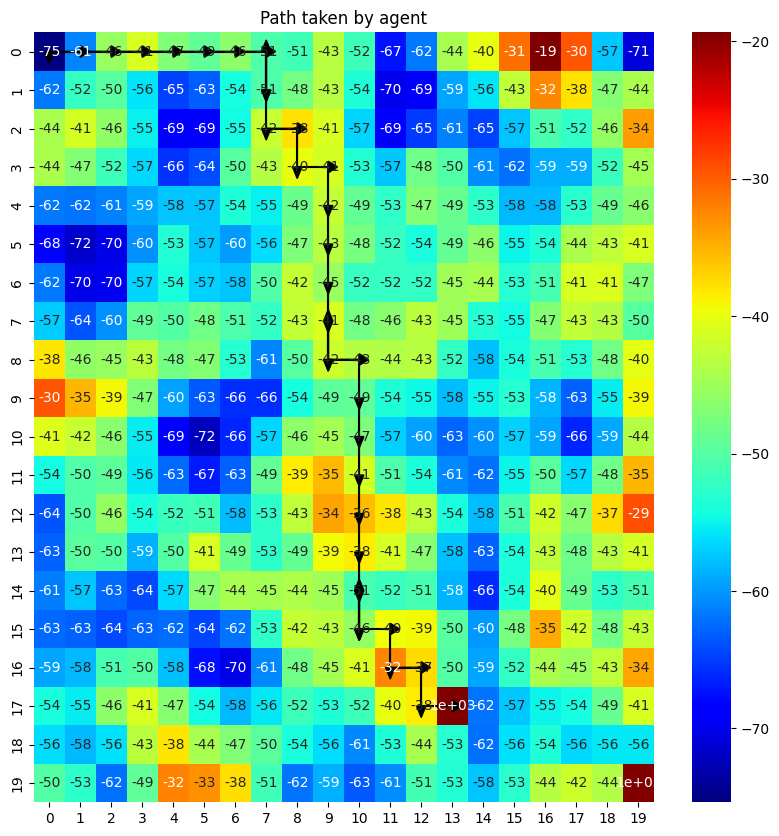

In [68]:
env = GridEnvironment(n_rows=20, n_cols=20, goal_states=[(17,13), (19,19)])
paths = env.run_training()
plot_path(paths[-1], env.reward_matrix, goal_states=env.goal_states)